# About
Demos of the following dimensionality reduction techniques:

1. PCA
1. t-SNE

**Disclaimer: I did not clean up this notebook too much so if you half run early cells and skip ahead things might break. Just rerun from the top again if needed**

## PCA

In [2]:
import os
import pandas as pd
import tools
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
data_folder = 'data/'
data = tools.read_all_csvs(data_folder)
for f in data.keys():
    cmd = "{} = data['{}']".format(f, f)
    exec(cmd)

In [73]:
# Extract numeric data
usable_listings = listings.select_dtypes(include = [np.number]).dropna(axis = 1, how = 'all')
usable_listings.fillna(value=0, inplace=True)

In [74]:
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
listings.columns

height has been deprecated.



Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Treating the review score as the "class".
Normally you'd want something more truly discrete as the class variable but this should be sufficiently illustrative.
To get a reasonable set of labels, we can group the scores by quartiles and use that.

In [75]:
stats = usable_listings['review_scores_rating'].describe()

def classify(row):
    if row['review_scores_rating'] <= stats['25%']:
        return "Very Bad"
    elif row['review_scores_rating'] > stats['25%'] and row['review_scores_rating'] < stats['50%']:
        return "OK"
    elif row['review_scores_rating'] > stats['50%'] and row['review_scores_rating'] < stats['75%']:
        return "Good"
    elif row['review_scores_rating'] >= stats['75%']:
        return "Very Good"

class_col = 'PCA_class'
y = usable_listings.apply(lambda row: classify(row), axis = 1)

### Standardization
In order for PCA to give meaningful results we need to scale the data so that it's reasonably comparable.
Otherwise the absolute variation won't necessarily be comparable as a measure of dataset variance.

In [76]:
from sklearn.preprocessing import StandardScaler
X_standardized = StandardScaler().fit_transform(usable_listings)

### Apply PCA
Use sklearn.decomposition.PCA

In [100]:
from sklearn.decomposition import PCA
num_comp = 2 # The number of principal components to include
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)

<IPython.core.display.Javascript object>


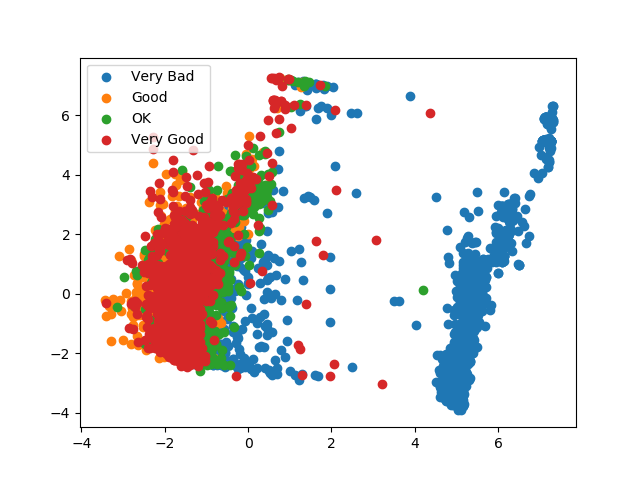

In [78]:
fig, ax = plt.subplots(1, 1)
for lab in y.unique():
    p = ax.scatter(y_est[y==lab, 0], y_est[y==lab, 1], label=lab)
ax.legend()

### Try different splits
Evidently the bottom quartile is terrible and can be separated this way.
We can try pruning further to get a better picture of the other clusters, which are currently still very close together.

<IPython.core.display.Javascript object>


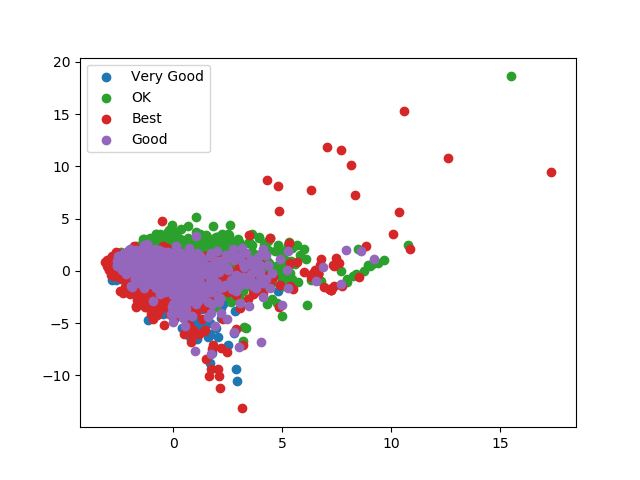

In [79]:
not_awful_listings = usable_listings.loc[usable_listings['review_scores_rating'] > stats['25%'], :]
not_awful_stats = not_awful_listings['review_scores_rating'].describe()

def not_awful_classify(row):
    if row['review_scores_rating'] <= not_awful_stats['25%']:
        return "OK"
    elif row['review_scores_rating'] > not_awful_stats['25%'] and row['review_scores_rating'] < not_awful_stats['50%']:
        return "Good"
    elif row['review_scores_rating'] > not_awful_stats['50%'] and row['review_scores_rating'] < not_awful_stats['75%']:
        return "Very Good"
    elif row['review_scores_rating'] >= not_awful_stats['75%']:
        return "Best"

class_col = 'PCA_class'
not_awful_y = not_awful_listings.apply(lambda row: not_awful_classify(row), axis = 1)
not_awful_X_standardized = StandardScaler().fit_transform(not_awful_listings)

not_awful_pca = PCA(n_components = num_comp)
not_awful_y_est = not_awful_pca.fit_transform(not_awful_X_standardized)

fig, ax = plt.subplots(1, 1)
for lab in not_awful_y.unique():
    p = ax.scatter(not_awful_y_est[not_awful_y==lab, 0], not_awful_y_est[not_awful_y==lab, 1], label=lab)
ax.legend()

Apparently in this case PCA primarily helps identify the bad spots.
Relatively unsurprising since people on AirBnB probably give good ratings to anything decent.
Therefore, we might need a better way to label our data.
However, going back to the original PCA it would be helpful to at least identify which features are contributing most to each component, i.e. what is causing the variance in a particular component.
We can do so as below.

In [96]:
print(pca.explained_variance_[0])
sorted(zip(pca.components_[0], usable_listings.columns), key= lambda x: abs(x[0]), reverse = True)

7.52171379012


[(-0.35366497180435269, 'review_scores_communication'),
 (-0.35326259654498976, 'review_scores_checkin'),
 (-0.35303394366725704, 'review_scores_rating'),
 (-0.35299075418151554, 'review_scores_value'),
 (-0.35274913346478953, 'review_scores_accuracy'),
 (-0.35005089266233014, 'review_scores_cleanliness'),
 (-0.34946463363952057, 'review_scores_location'),
 (-0.17068662428172043, 'reviews_per_month'),
 (-0.13962105981098233, 'number_of_reviews'),
 (0.13254690939541824, 'host_listings_count'),
 (0.13254690939541824, 'host_total_listings_count'),
 (0.12258115040730032, 'calculated_host_listings_count'),
 (0.098190504413634624, 'id'),
 (0.088452205581855139, 'availability_30'),
 (0.066330146365960352, 'host_id'),
 (0.05717061866556631, 'availability_60'),
 (-0.055962632755562708, 'guests_included'),
 (0.039498776648549158, 'availability_90'),
 (0.0313572488907757, 'minimum_nights'),
 (0.023153551998051618, 'latitude'),
 (0.022066226888282754, 'bathrooms'),
 (-0.018608344050325579, 'longit

In [99]:
print(pca.explained_variance_[1])
sorted(zip(pca.components_[1], usable_listings.columns), key= lambda x: abs(x[0]), reverse = True)

4.31654979444


[(0.38943168678578582, 'availability_60'),
 (0.38343074432251001, 'availability_90'),
 (0.37502629766656681, 'availability_30'),
 (0.32620430519095617, 'calculated_host_listings_count'),
 (0.32465866949064109, 'host_listings_count'),
 (0.32465866949064109, 'host_total_listings_count'),
 (0.29878772956491151, 'availability_365'),
 (0.18772897510537886, 'accommodates'),
 (0.15304553422017303, 'bedrooms'),
 (0.14928426978943679, 'bathrooms'),
 (0.14812709370664465, 'beds'),
 (0.085429890642111261, 'review_scores_cleanliness'),
 (0.074310932594831056, 'review_scores_rating'),
 (0.073794931695498167, 'review_scores_accuracy'),
 (0.073578246993772495, 'review_scores_location'),
 (0.071504526912869654, 'review_scores_checkin'),
 (0.070914601103431674, 'review_scores_communication'),
 (-0.06887383263037121, 'host_id'),
 (0.067414932138698827, 'review_scores_value'),
 (0.064291420481688302, 'guests_included'),
 (0.033064370881471718, 'number_of_reviews'),
 (0.032944701090908649, 'longitude'),
 

The first principal component is rather boring, since it basically just says tells us again that the classes are based on reviews.
The second principal component is a little more interesting, since it at least tells us that availability is critical.
Also, both components correlate with how many listings the host has; someone who has multiple listings tends to be more experienced and do a better job.
Finally, it could be helpful to see how useful each component is; for this it is worth looking at a larger set of components to understand how big the dropoff is.

In [106]:
num_comp = 8
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)
pca.explained_variance_ratio_

array([ 0.26863264,  0.15416249,  0.10981693,  0.07459985,  0.05954989,
        0.0519828 ,  0.03929117,  0.035376  ])

After the first component, there is some signficiant dropoff, but at least the first 3-4 components appear significant enough to be worth investigating.

## t-SNE
Note that t-SNE is very slow, and is therefore likely to not be worth running for larger datasets.
A standard practice is to use PCA to reduce the dataset first.

In [108]:
from sklearn.manifold import TSNE
num_comp = 2 # The number of principal components to include
tsne = TSNE(n_components = num_comp, verbose=1)
tsne_y_est = tsne.fit_transform(X_standardized)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4870
[t-SNE] Computed conditional probabilities for sample 2000 / 4870
[t-SNE] Computed conditional probabilities for sample 3000 / 4870
[t-SNE] Computed conditional probabilities for sample 4000 / 4870
[t-SNE] Computed conditional probabilities for sample 4870 / 4870
[t-SNE] Mean sigma: 1.026655
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.556478
[t-SNE] Error after 325 iterations: 1.556478


<IPython.core.display.Javascript object>


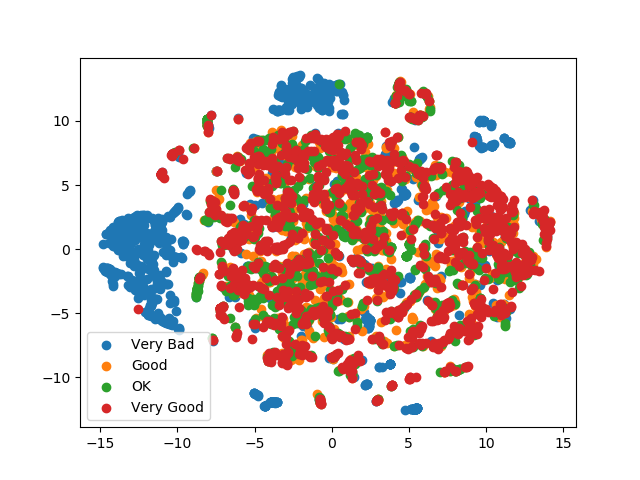

In [109]:
fig, ax = plt.subplots(1, 1)
for lab in y.unique():
    p = ax.scatter(tsne_y_est[y==lab, 0], tsne_y_est[y==lab, 1], label=lab)
ax.legend()

To actually run t-SNE on PCA reduced data, we need to compute the principal components, project into this new basis, and then perform dimensionality reduction on this new basis.

In [110]:
num_comp = 20
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)

num_comp = 2
tsne_pca = TSNE(n_components = num_comp, verbose=1)
tsne_pca_y_est = tsne_pca.fit_transform(y_est)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4870
[t-SNE] Computed conditional probabilities for sample 2000 / 4870
[t-SNE] Computed conditional probabilities for sample 3000 / 4870
[t-SNE] Computed conditional probabilities for sample 4000 / 4870
[t-SNE] Computed conditional probabilities for sample 4870 / 4870
[t-SNE] Mean sigma: 1.018468
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.551911
[t-SNE] Error after 450 iterations: 1.551911


<IPython.core.display.Javascript object>


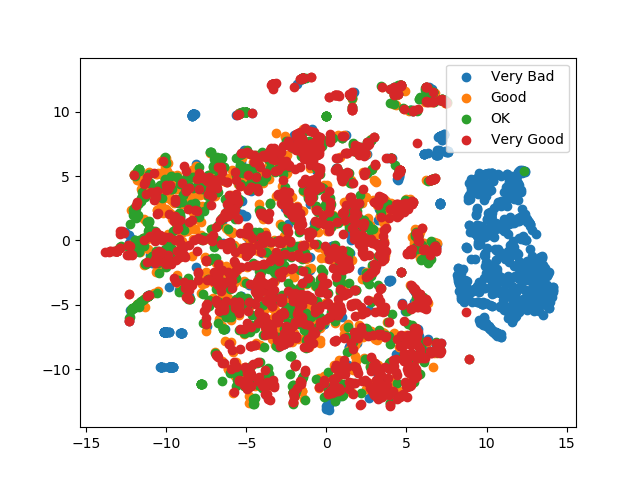

In [111]:
fig, ax = plt.subplots(1, 1)
for lab in y.unique():
    p = ax.scatter(tsne_pca_y_est[y==lab, 0], tsne_pca_y_est[y==lab, 1], label=lab)
ax.legend()

In all cases, we see again that both of these dimensionality reduction techniques basically just serve to weed out the very bad AirBnBs.
To do a better job, we'll need to try out different classifiers.